In [8]:
import numpy as np
import scipy.sparse
import PIL.Image
import pyamg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [18]:
# pre-process the mask array so that uint64 types from opencv.imread can be adapted
def prepare_mask(mask):
    if type(mask[0][0]) is np.ndarray:
        result = np.ndarray((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if sum(mask[i][j]) > 0:
                    result[i][j] = 1
                else:
                    result[i][j] = 0
        mask = result
    return mask

In [9]:
def blend(img_target, img_source, img_mask, offset=(0, 0)):
    # compute regions to be blended
    region_source = (
            max(-offset[0], 0),
            max(-offset[1], 0),
            min(img_target.shape[0]-offset[0], img_source.shape[0]),
            min(img_target.shape[1]-offset[1], img_source.shape[1]))
    region_target = (
            max(offset[0], 0),
            max(offset[1], 0),
            min(img_target.shape[0], img_source.shape[0]+offset[0]),
            min(img_target.shape[1], img_source.shape[1]+offset[1]))
    region_size = (region_source[2]-region_source[0], region_source[3]-region_source[1])

    # clip and normalize mask image
    img_mask = img_mask[region_source[0]:region_source[2], region_source[1]:region_source[3]]
    img_mask = prepare_mask(img_mask)
    img_mask[img_mask==0] = False
    img_mask[img_mask!=False] = True

    # create coefficient matrix
    A = scipy.sparse.identity(np.prod(region_size), format='lil')
    for y in range(region_size[0]):
        for x in range(region_size[1]):
            if img_mask[y,x]:
                index = x+y*region_size[1]
                A[index, index] = 4
                if index+1 < np.prod(region_size):
                    A[index, index+1] = -1
                if index-1 >= 0:
                    A[index, index-1] = -1
                if index+region_size[1] < np.prod(region_size):
                    A[index, index+region_size[1]] = -1
                if index-region_size[1] >= 0:
                    A[index, index-region_size[1]] = -1
    A = A.tocsr()
    
    # create poisson matrix for b
    P = pyamg.gallery.poisson(img_mask.shape)

    # for each layer (ex. RGB)
    for num_layer in range(img_target.shape[2]):
        # get subimages
        t = img_target[region_target[0]:region_target[2],region_target[1]:region_target[3],num_layer]
        s = img_source[region_source[0]:region_source[2], region_source[1]:region_source[3],num_layer]
        t = t.flatten()
        s = s.flatten()

        # create b
        b = P * s
        for y in range(region_size[0]):
            for x in range(region_size[1]):
                if not img_mask[y,x]:
                    index = x+y*region_size[1]
                    b[index] = t[index]

        # solve Ax = b
        x = pyamg.solve(A,b,verb=False,tol=1e-10)

        # assign x to target image
        x = np.reshape(x, region_size)
        x[x>255] = 255
        x[x<0] = 0
        x = np.array(x, img_target.dtype)
        img_target[region_target[0]:region_target[2],region_target[1]:region_target[3],num_layer] = x

    return img_target

In [16]:
def test():
    img_mask = np.asarray(PIL.Image.open('./testimages/test1_mask.png'))
    img_mask.flags.writeable = True
    img_source = np.asarray(PIL.Image.open('./testimages/test1_src.png'))
    img_source.flags.writeable = True
    img_target_origin = np.asarray(PIL.Image.open('./testimages/test1_target.png'))
    img_target = img_target_origin.copy()
    img_target.flags.writeable = True
    img_ret = blend(img_target, img_source, img_mask, offset=(40,-30))
    img_ret = PIL.Image.fromarray(np.uint8(img_ret))
    img_ret.save('./testimages/test1_ret.png')
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.imshow(img_mask)
    plt.title("mark")
    plt.subplot(1,4,2)
    plt.imshow(img_source)
    plt.title("src")
    plt.subplot(1,4,3)
    plt.imshow(img_target_origin)
    plt.title("target")
    plt.subplot(1,4,4)
    plt.imshow(img_ret)
    plt.title("result")
    plt.show()

c:\users\jsjtx\anaconda3\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
c:\users\jsjtx\anaconda3\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


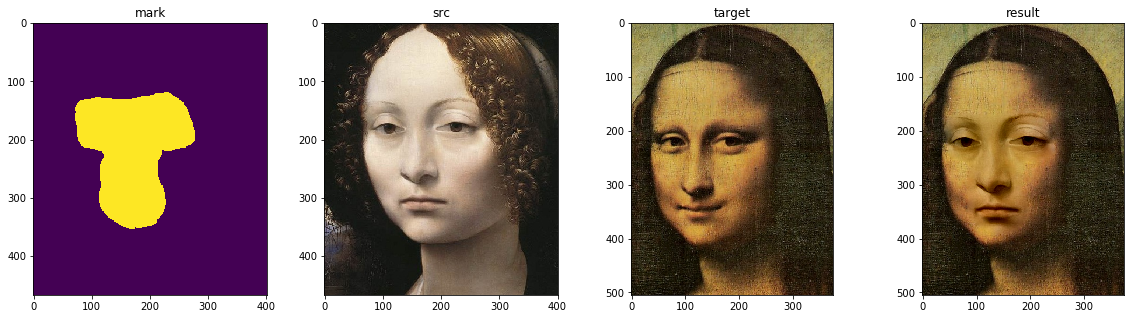

In [17]:
test()